In [ ]:
dir1 = "datashopify1"
dir2 = "datashopify2"
dir3 = "datashopify3"

In [ ]:
customers = pd.read_csv(os.path.join(dir2, "shopify_customers_dataset.csv"))
    orders = pd.read_csv(os.path.join(dir1, "shopify_orders_dataset.csv"))
    order_items = pd.read_csv(os.path.join(dir2, "shopify_order_items_dataset.csv"))
    payments = pd.read_csv(os.path.join(dir1, "shopify_order_payments_dataset 2.csv"))
    products = pd.read_csv(os.path.join(dir1, "shopify_products_dataset.csv"))
    sellers = pd.read_csv(os.path.join(dir1, "shopify_sellers_dataset.csv"))
    product_category = pd.read_csv(os.path.join(dir2, "product_category_name_translation.csv"))
    geolocation = pd.read_csv(os.path.join(dir3, "shopify_geolocation_dataset.csv"))

*** Hay que revisar la tabla de órdenes que no tenga inconsistencias con el estado de la orden y las fechas*** También hay que modificar los datos de fecha y convertirlos

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
orders['Fecha_compra'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['Fecha:aprobacion'] = pd.to_datetime(orders['order_approved_at'])
orders['Fecha_envio'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['Fecha_entrega'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['Fecha_estimada_entrega'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [ ]:
orders["tiempo_envio_entrega"] = (
    orders["Fecha_entrega"] - orders["Fecha_envio"]
).dt.days

In [ ]:
orders["tiempo_aprobado_enviado"] = (
    orders["Fecha_envio"] - orders["Fecha:aprobacion"]
).dt.days

In [ ]:
orders["tiempo_aprobado_enviado"].describe()

,tiempo_aprobado_enviado
count,97644.000000
mean,2.301749
std,3.560283
min,-172.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,125.000000


El promedio de tiempo de entrega y envío es 8.8 días

In [ ]:
orders["tiempo_envio_entrega"].describe()

,tiempo_envio_entrega
count,96475.000000
mean,8.878310
std,8.746088
min,-17.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,205.000000


In [ ]:
tiempo_promedio = orders["tiempo_envio_entrega"].mean()


In [ ]:
orders["order_status"].value_counts(0)

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


En mi data set hay 96478 ordenes identificadas como entregadas pero en el número de observaciones con fecha de entrega al cliente es mayor, lo que significa que tengo ordenes que no está actualizado su status

**Con el siguiente codigo corrijo todas las observaciones que su estado dice entregado pero que no tiene fecha de entrega y si fecha de envío.**

In [ ]:
orders["status_corregido"] = orders.apply(lambda x: "delivered" if((x["order_status"]!="delivered") & (pd.notna(x["Fecha_entrega"]))) else x["order_status"], axis =1 )

In [ ]:
orders["status_corregido"] = orders.apply ( lambda x : " shipped" if ((x["status_corregido"]== "delivered") & (pd.isna(x["Fecha_entrega"])) & (pd.notna(x["Fecha_envio"]))) else x["status_corregido"], axis = 1)

In [ ]:
orders["status_corregido"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', ' shipped', 'created', 'approved'], dtype=object)

***Con el siguiente codigo corrijo todas las órdenes que tienen fecha de entrega pero no aparecen en estado entregado. ***

***Con el siguiente código corrijo la observación que tiene status entregado pero no fecha de entrega. ***

In [ ]:
orders["status_corregido"] = orders.apply(lambda x : "shipped" if ((x["order_status"]== "delivered") & (pd.isna(x["Fecha_entrega"])) & (pd.notna(x["Fecha_envio"]))) else x["order_status"], axis = 1)

***Con el siguiente codigo corrijo aquellas ordenes identificadas como canceladas pero que si fueron entregadas, corrijo el estado a entregado ***

In [ ]:
orders["status_corregido"] = orders. apply( lambda x : "delivered" if ((x["status_corregido"] !="canceled") & (pd.notna(x["Fecha_entrega"]))) else x["status_corregido"], axis = 1)

***Hay un dato que no me estaba leyendo como Nan asi que lo convierto a nulo para poder identificarlo y hacer el cambio ***

In [ ]:
import numpy as np
orders["Fecha_compra"].replace("", np.nan, inplace=True)
orders["Fecha_envio"].replace("", np.nan, inplace=True)
orders["Fecha_entrega"].replace("", np.nan, inplace=True)
orders["Fecha_estimada_entrega"].replace("", np.nan, inplace=True)

/tmp/ipython-input-17-985066674.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders["Fecha_compra"].replace("", np.nan, inplace=True)
/tmp/ipython-input-17-985066674.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

***A la fila que encontré con  la inconsistencia le aplique loc para hacer el cambio solo en esa fila ***

In [ ]:
orders.loc[92643, "status_corregido"] = "approved"

**Ahora empezamos a buscar inconsistencias en los que dicen estado enviados y no tienen fecha de envío registrada**
**texto en negrita**
```

```



Se comprueba que no hay observaciones en estado enviado que no tengan la fecha de envío registrada

In [ ]:
orders[(orders["status_corregido"]== "shipped") & (orders["Fecha_envio"].isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido


Revisando en Shoppify, un pedido que ya haya sido enviado no puede ser cancelado, por ende todas las observaciones que indican cancelado y tienen fecha de envío deben ser limpiadas y registradas como enviados.

In [ ]:
filtrocanceladas_enviadas = ((orders["status_corregido"] != "shipped") &(orders["status_corregido"] != "delivered")) & (orders["Fecha_envio"].notna())


In [ ]:
orders.loc[filtrocanceladas_enviadas, "status_corregido"] = "shipped"

**Tengo una observación que no tiene fecha de envío pero si está entregada, está la voy a imputar con la mediana del tiempo que tarda en pasar de aprobado a enviado que es 1 día.**

In [ ]:
filtro = (orders["status_corregido"].isin(["shipped", "delivered"])) & (orders["Fecha_envio"].isna())
orders[filtro]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaN,2017-11-20 19:44:47,2017-11-14 00:00:00,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,NaN,NaN,delivered


In [ ]:
orders.loc[73222, "Fecha_envio"] = "2017-09-30"

Hay que revisar las ordenes procesadas, facturadas, aprobadas, creadas.
Para el ejercicio yo quiero analizar lo vendido realmente, por lo que, las que están en estado creado,  facturado no se pueden considerar compra final debo revisar si no tienen fecha de envío o aprobación para descartarlas.  

In [ ]:
orders.loc[73222]

,73222
order_id,2aa91108853cecb43c84a5dc5b277475
customer_id,afeb16c7f46396c0ed54acb45ccaaa40
order_status,delivered
order_purchase_timestamp,2017-09-29 08:52:58
order_approved_at,2017-09-29 09:07:16
order_delivered_carrier_date,NaN
order_delivered_customer_date,2017-11-20 19:44:47
order_estimated_delivery_date,2017-11-14 00:00:00
Fecha_compra,2017-09-29 08:52:58
Fecha:aprobacion,2017-09-29 09:07:16


In [ ]:
orders[ (orders["status_corregido"]== "invoiced") & ( orders["Fecha_entrega"].notna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido


In [ ]:
orders[ (orders["status_corregido"]== "invoiced") & ( orders["Fecha_envio"].notna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido


Las 314 que indica facturadas aparecen con fecha de aprobación, en consecuente, las puedo considerar como compras reales.

In [ ]:
orders["status_corregido"] = orders.apply(lambda x : "approved" if ((x["status_corregido"]== "invoiced"))else x["status_corregido"], axis=1)

In [ ]:
orders[ (orders["status_corregido"]== "invoiced") & ( orders["Fecha:aprobacion"].notna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido


No hay ordenes en estado procesadas sin fecha de aprobación, por lo que las puedo considerar como aprobadas , con apply modifico estos datos.

In [ ]:
orders[(orders["status_corregido"]=="processing")& (orders["Fecha:aprobacion"].isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido


In [ ]:
orders["status_corregido"]= orders.apply(lambda x : "approved" if ((x["status_corregido"]== "processing"))else x["status_corregido"], axis=1)

Las ordenes que tienen estatus no disponible no las voy a considerar para el análisis, se entiende que no hay venta real porque no se despachara.

In [ ]:
orders[(orders["status_corregido"]== "unavailable") & ((orders["Fecha:aprobacion"].notna()) | (orders["Fecha_envio"].notna()) | (orders["Fecha_entrega"].notna()))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,NaN,NaN,unavailable
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,NaN,NaN,unavailable
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,NaN,NaN,unavailable
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06,NaN,NaN,unavailable
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaN,2017-10-27 00:00:00,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27,NaN,NaN,unavailable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaN,NaN,2017-10-27 00:00:00,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27,NaN,NaN,unavailable
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaN,NaN,2018-01-19 00:00:00,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19,NaN,NaN,unavailable
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,NaN,NaN,unavailable
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,NaN,NaN,unavailable


No hay ordenes canceladas en estado enviadas, por ende, se pueden eliminar del análisis.

In [ ]:
orders[(orders["status_corregido"]== "canceled") & (orders["Fecha_envio"].notna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido


Para el data set filtrado, sólo usaremos las ventas reales, por lo que, las ordenes no disponibles y canceladas se eliminar del data set.

In [ ]:
ordenes_reales = orders[(orders["status_corregido"]=="delivered") | (orders["status_corregido"]=="approved") | (orders["status_corregido"]=="shipped")].reset_index(drop=True)

In [ ]:
ordenes_reales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98277 entries, 0 to 98276
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98277 non-null  object        
 1   customer_id                    98277 non-null  object        
 2   order_status                   98277 non-null  object        
 3   order_purchase_timestamp       98277 non-null  object        
 4   order_approved_at              98263 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  98277 non-null  object        
 8   Fecha_compra                   98277 non-null  datetime64[ns]
 9   Fecha:aprobacion               98263 non-null  datetime64[ns]
 10  Fecha_envio                    97659 non-null  datetime64[ns]
 11  Fecha_entrega  

Aquí vemos de ordenes ya entregadas pero sin fecha de aprobación, como ultimo paso puedo imputar la fecha de aprobación con la media de tiempo en que se hace la compra y se aprueba, esto es en el mismo día. Imputo con el mismo día

In [ ]:
ordenes_reales["tiempo_compra_aprobacion"] = (
    ordenes_reales["Fecha:aprobacion"] - ordenes_reales["Fecha_compra"]
).dt.days

In [ ]:
ordenes_reales["tiempo_compra_aprobacion"].describe()

,tiempo_compra_aprobacion
count,98263.000000
mean,0.265420
std,0.763423
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,60.000000


In [ ]:
ordenes_reales[ordenes_reales["Fecha:aprobacion"].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Fecha_compra,Fecha:aprobacion,Fecha_envio,Fecha_entrega,Fecha_estimada_entrega,tiempo_envio_entrega,tiempo_aprobado_enviado,status_corregido,tiempo_compra_aprobacion
5273,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,6.0,NaN,delivered,NaN
16380,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,7.0,NaN,delivered,NaN
18814,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,6.0,NaN,delivered,NaN
22399,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,14.0,NaN,delivered,NaN
22887,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,7.0,NaN,delivered,NaN
26481,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01 00:00:00,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,5.0,NaN,delivered,NaN
37853,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,7.0,NaN,delivered,NaN
38884,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaN,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22 00:00:00,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,7.0,NaN,delivered,NaN
47829,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaN,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16 00:00:00,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,10.0,NaN,delivered,NaN
61022,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaN,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20 00:00:00,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,9.0,NaN,delivered,NaN


Creo un filtro para imputar con la misma fecha de compra la fecha de aprobacion

In [ ]:
ordenes_reales = orders[(orders["status_corregido"]=="delivered") | (orders["status_corregido"]=="approved") | (orders["status_corregido"]=="shipped")].reset_index(drop=True)

filtro_entregadas_sin_aprobacion = (
    (ordenes_reales["status_corregido"] == "delivered") &
    (ordenes_reales["Fecha:aprobacion"].isna())
)
print(ordenes_reales[filtro_entregadas_sin_aprobacion].shape[0])

14


In [ ]:
ordenes_reales.loc[filtro_entregadas_sin_aprobacion, "Fecha:aprobacion"] = \
    ordenes_reales.loc[filtro_entregadas_sin_aprobacion, "Fecha_compra"]

In [ ]:
ordenes_reales.loc[filtro_entregadas_sin_aprobacion, ["Fecha_compra", "Fecha:aprobacion"]]

,Fecha_compra,Fecha:aprobacion
5273,2017-02-18 14:40:00,2017-02-18 14:40:00
16380,2017-02-18 12:45:31,2017-02-18 12:45:31
18814,2017-02-18 13:29:47,2017-02-18 13:29:47
22399,2017-02-18 16:48:35,2017-02-18 16:48:35
22887,2017-02-17 13:05:55,2017-02-17 13:05:55
26481,2017-01-19 12:48:08,2017-01-19 12:48:08
37853,2017-02-19 01:28:47,2017-02-19 01:28:47
38884,2017-02-18 11:04:19,2017-02-18 11:04:19
47829,2017-01-19 22:26:59,2017-01-19 22:26:59
61022,2017-02-17 17:21:55,2017-02-17 17:21:55


In [ ]:
ordenes_reales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98277 entries, 0 to 98276
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98277 non-null  object        
 1   customer_id                    98277 non-null  object        
 2   order_status                   98277 non-null  object        
 3   order_purchase_timestamp       98277 non-null  object        
 4   order_approved_at              98263 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  98277 non-null  object        
 8   Fecha_compra                   98277 non-null  datetime64[ns]
 9   Fecha:aprobacion               98277 non-null  datetime64[ns]
 10  Fecha_envio                    97659 non-null  datetime64[ns]
 11  Fecha_entrega  

In [ ]:
ordenes_reales["status_corregido"].value_counts()

,count
status_corregido,
delivered,96470
shipped,1189
approved,618


# Limpieza de la tabla con información de los productos pedidos

In [ ]:
orders["order_id"].nunique()

99441

In [ ]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
order_items["order_id"].nunique()

98666

In [ ]:
ordenes_items = pd.merge(ordenes_reales, order_items, on="order_id", how="inner")

Para el nuevo data set voy a eliminar las columnas que ya fueron corregidas con el fin de quedarme con un data set limpio

In [ ]:
ordenes_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112177 entries, 0 to 112176
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112177 non-null  object        
 1   customer_id                    112177 non-null  object        
 2   order_status                   112177 non-null  object        
 3   order_purchase_timestamp       112177 non-null  object        
 4   order_approved_at              112162 non-null  object        
 5   order_delivered_carrier_date   111456 non-null  object        
 6   order_delivered_customer_date  110196 non-null  object        
 7   order_estimated_delivery_date  112177 non-null  object        
 8   Fecha_compra                   112177 non-null  datetime64[ns]
 9   Fecha:aprobacion               112177 non-null  datetime64[ns]
 10  Fecha_envio                    111457 non-null  datetime64[ns]
 11  

In [ ]:
ordenes_items["order_id"].nunique()

98274

In [ ]:
ordenes_items["status_corregido"].value_counts()

,count
status_corregido,
delivered,110189
shipped,1268
approved,720


Limpieza de order payments

In [ ]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [ ]:
payments["order_id"].nunique()

99440

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
ordenes_items = pd.merge(ordenes_items, products, on="product_id", how="inner")

In [ ]:
ordenes_items = pd.merge(ordenes_items, customers, on="customer_id", how="inner")

In [ ]:
ordenes_items = pd.merge(ordenes_items, nombrecategorias, on="product_category_name", how="inner")

In [ ]:
base_total = pd.merge(ordenes_items, payments, on="order_id", how="inner")

In [ ]:
base_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115399 entries, 0 to 115398
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115399 non-null  object        
 1   customer_id                    115399 non-null  object        
 2   order_status                   115399 non-null  object        
 3   order_purchase_timestamp       115399 non-null  object        
 4   order_approved_at              115385 non-null  object        
 5   order_delivered_carrier_date   114673 non-null  object        
 6   order_delivered_customer_date  113383 non-null  object        
 7   order_estimated_delivery_date  115399 non-null  object        
 8   Fecha_compra                   115399 non-null  datetime64[ns]
 9   Fecha:aprobacion               115399 non-null  datetime64[ns]
 10  Fecha_envio                    114674 non-null  datetime64[ns]
 11  

In [ ]:
base_total["order_id"].nunique()

96877

In [ ]:
base_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115399 entries, 0 to 115398
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115399 non-null  object        
 1   customer_id                    115399 non-null  object        
 2   order_status                   115399 non-null  object        
 3   order_purchase_timestamp       115399 non-null  object        
 4   order_approved_at              115385 non-null  object        
 5   order_delivered_carrier_date   114673 non-null  object        
 6   order_delivered_customer_date  113383 non-null  object        
 7   order_estimated_delivery_date  115399 non-null  object        
 8   Fecha_compra                   115399 non-null  datetime64[ns]
 9   Fecha:aprobacion               115399 non-null  datetime64[ns]
 10  Fecha_envio                    114674 non-null  datetime64[ns]
 11  

Le voy a eliminar columnas que ya no necesito porque están convertidas o duplicadas

Cuando hice el merge pandas me duplico columnas y las renombro con x y y . Neecesito borrarlas

In [ ]:
columnas_x = [col for col in base_total.columns if col.endswith('_x')]
columnas_y = [col for col in base_total.columns if col.endswith('_y')]

In [ ]:
duplicadas_base = [col.replace('_x', '') for col in columnas_x if col.replace('_x', '_y') in columnas_y]

In [ ]:
columnas_y_a_eliminar = [col + '_y' for col in duplicadas_base]
base_total = base_total.drop(columns=columnas_y_a_eliminar)

A mi base filtrada y unida con las otras tablas le voy asignar un nuevo nombre : ordenes_filtradas

In [ ]:
ordenes_filtradas = base_total

In [ ]:
ordenes_filtradas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115399 entries, 0 to 115398
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115399 non-null  object        
 1   customer_id                    115399 non-null  object        
 2   order_status                   115399 non-null  object        
 3   order_purchase_timestamp       115399 non-null  object        
 4   order_approved_at              115385 non-null  object        
 5   order_delivered_carrier_date   114673 non-null  object        
 6   order_delivered_customer_date  113383 non-null  object        
 7   order_estimated_delivery_date  115399 non-null  object        
 8   Fecha_compra                   115399 non-null  datetime64[ns]
 9   Fecha:aprobacion               115399 non-null  datetime64[ns]
 10  Fecha_envio                    114674 non-null  datetime64[ns]
 11  

In [ ]:
base_total["payment_value"].sum()

np.float64(19907237.909999996)

In [ ]:
from time import asctime
base_total.groupby("status_corregido")["payment_value"].sum().sort_values(ascending=False)

,payment_value
status_corregido,
delivered,19527575.22
shipped,200617.97
approved,179044.72


In [ ]:
base_total["payment_value"].describe()

,payment_value
count,115399.000000
mean,172.507889
std,266.484203
min,0.000000
25%,61.010000
50%,108.190000
75%,189.480000
max,13664.080000


In [ ]:
base_total.groupby("status_corregido").agg({"payment_value" : sum , "order_id" : "nunique"}).sort_values(by="payment_value", ascending=False)

/tmp/ipython-input-68-2184055175.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  base_total.groupby("status_corregido").agg({"payment_value" : sum , "order_id" : "nunique"}).sort_values(by="payment_value", ascending=False)


,payment_value,order_id
status_corregido,,
delivered,19527575.22,95118
shipped,200617.97,1162
approved,179044.72,597


In [ ]:
frm_df = base_total.groupby("customer_unique_id").agg({
    "Fecha_compra": ["max", "count"],
    "payment_value": "sum"
})
frm_df

Fecha_compra       payment_value
                                                 max count           sum
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27     1        141.90
0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27     1         27.19
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03     1         86.22
0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41     1         43.62
0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42     1        196.89
...                                              ...   ...           ...
fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:00:36     2       4134.84
fffea47cd6d3cc0a88bd621562a9d061 2017-12-10 20:07:56     1         84.58
ffff371b4d645b6ecea244b27531430a 2017-02-07 15:49:16     1        112.46
ffff5962728ec6157033ef9805bacc48 2018-05-02 15:17:41     1        133.69
ffffd2657e2aad2907e67c3e9daecbeb 2017-05-02 20:18:45     1         71.56

[93731 rows x 3 columns]

In [ ]:
orders["customer_id"].nunique()

99441

In [ ]:
base_total["customer_unique_id"].nunique()

93731

***Primero calculo mi fecha de referencia de todo el data set ***




In [ ]:
fecha_ref = base_total["Fecha_compra"].max() + pd.Timedelta(days=1)

**Ahora calculo el recency, frequency y monetary**

In [ ]:
rfm = base_total.groupby("customer_unique_id").agg({
    "Fecha_compra": lambda x: (fecha_ref - x.max()).days,   # Recency
    "customer_unique_id": "count",                          # Frequency
    "payment_value": "sum"                                  # Monetary
})
rfm.columns = ["Recency", "Frequency", "Monetary"]

**Asigno** puntuaciones al RFM

In [ ]:
# Recency: menor es mejor (más reciente)
rfm["R_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])

# Frequency y Monetary: mayor es mejor
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

In [ ]:
rfm["RFM_score"] = rfm["R_score"].astype(str) + rfm["F_score"].astype(str) + rfm["M_score"].astype(str)
rfm["RFM_score"]

,RFM_score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,414
0000b849f77a49e4a4ce2b2a4ca5be3f,411
0000f46a3911fa3c0805444483337064,112
0000f6ccb0745a6a4b88665a16c9f078,211
0004aac84e0df4da2b147fca70cf8255,214
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,155
fffea47cd6d3cc0a88bd621562a9d061,352
ffff371b4d645b6ecea244b27531430a,153


In [ ]:
def segmentar_cliente(rfm):
    score = rfm["RFM_score"]
    if score.startswith("5") and score[1] in "45" and score[2] in "45":
        return "Top Cliente"
    elif score.startswith("4") and score[1] in "34" and score[2] in "34":
        return "Cliente Leal"
    elif score[0] in "34" and score[1] in "12":
        return "Cliente Prometedor"
    elif score.startswith("1") and score[1] in "12":
        return "En Riesgo"
    elif score == "111":
        return "Inactivo"
    else:
        return "Otros"

In [ ]:
rfm["segmento"] = rfm.apply(segmentar_cliente, axis=1)
rfm["segmento"].value_counts(1).sort_values(ascending=False)

,proportion
segmento,
Otros,0.684992
Cliente Prometedor,0.160096
En Riesgo,0.080219
Top Cliente,0.040840
Cliente Leal,0.033852


In [ ]:
conteo_segmentos = rfm["segmento"].value_counts()
print(conteo_segmentos)

segmento
Otros                 64205
Cliente Prometedor    15006
En Riesgo              7519
Top Cliente            3828
Cliente Leal           3173
Name: count, dtype: int64


/tmp/ipython-input-77-1310520551.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_segmentos.index, y=conteo_segmentos.values, palette="viridis")


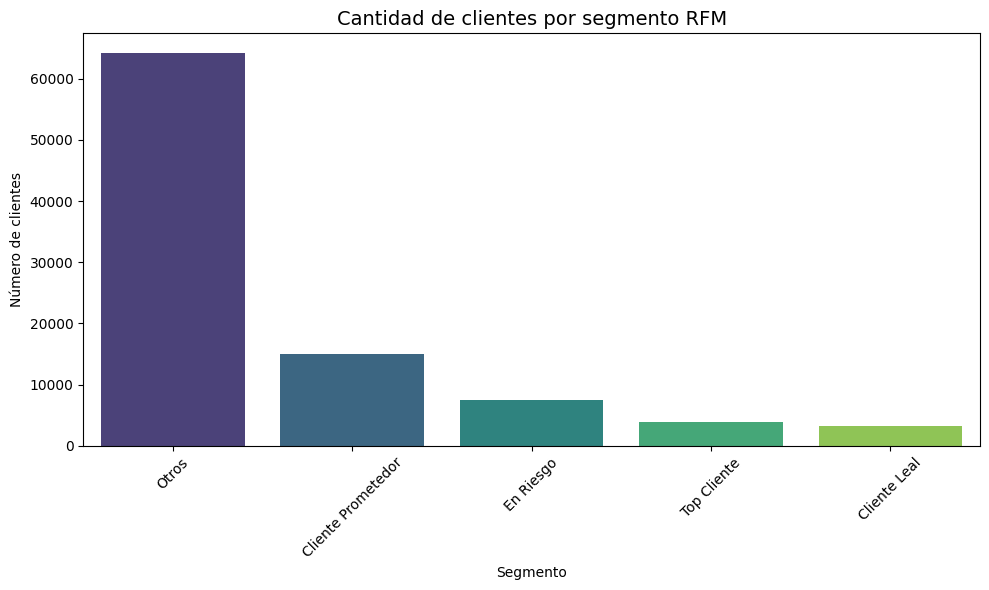

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=conteo_segmentos.index, y=conteo_segmentos.values, palette="viridis")
# Títulos
plt.title("Cantidad de clientes por segmento RFM", fontsize=14)
plt.xlabel("Segmento")
plt.ylabel("Número de clientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Crear un DataFrame con Recency y Frequency
rfm_heatmap = rfm.groupby(['R_score', 'F_score']).size().unstack(fill_value=0)

# Ordenar para una mejor visualización
rfm_heatmap = rfm_heatmap.sort_index(ascending=False, axis=0)  # Recency de más reciente a menos
rfm_heatmap = rfm_heatmap.sort_index(ascending=True, axis=1)   # Frequency de más alta a baja

/tmp/ipython-input-78-1399280764.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_heatmap = rfm.groupby(['R_score', 'F_score']).size().unstack(fill_value=0)


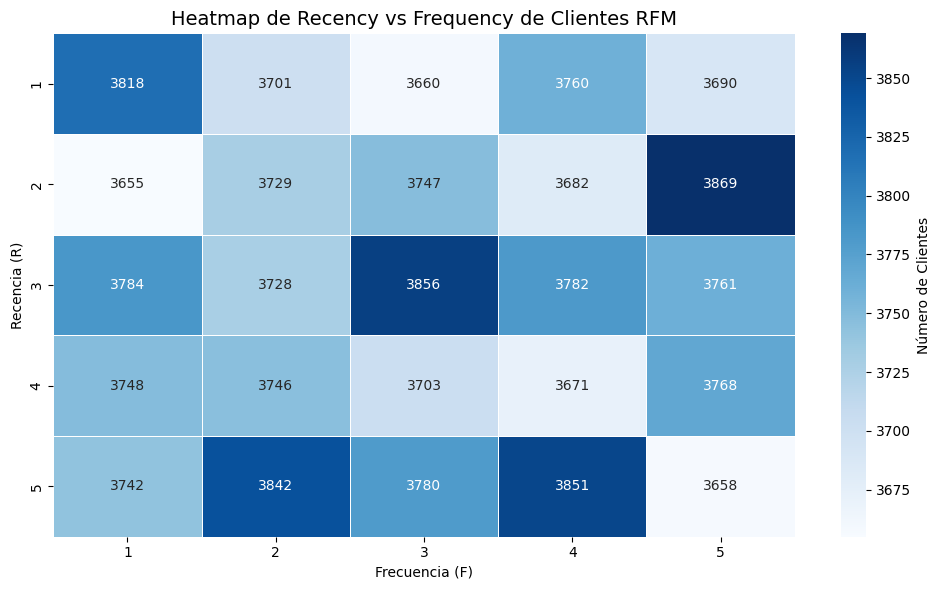

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(rfm_heatmap, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Número de Clientes'})

plt.title("Heatmap de Recency vs Frequency de Clientes RFM", fontsize=14)
plt.xlabel("Frecuencia (F)")
plt.ylabel("Recencia (R)")
plt.tight_layout()
plt.show()

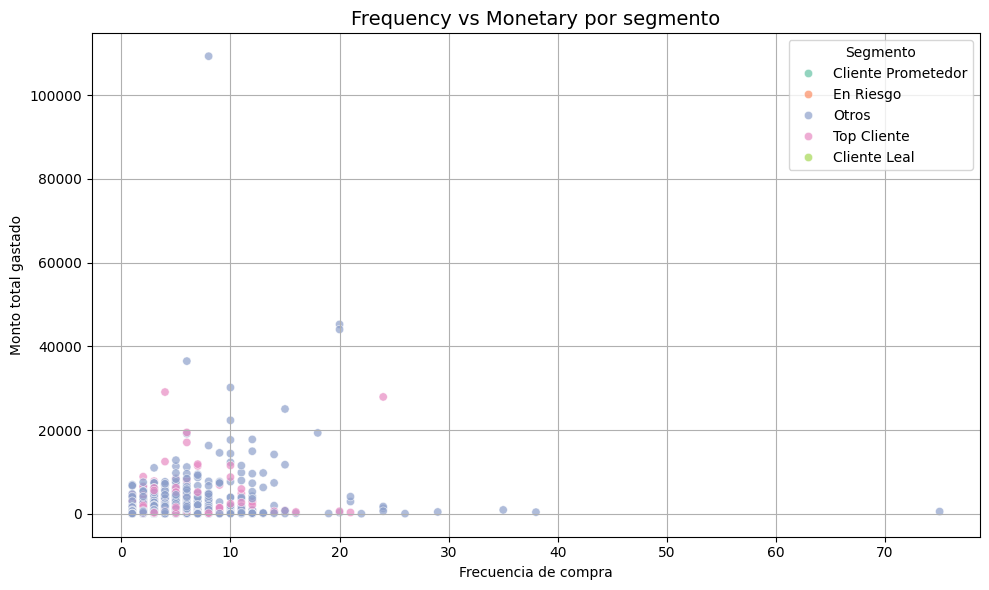

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="segmento", palette="Set2", alpha=0.7)

plt.title("Frequency vs Monetary por segmento", fontsize=14)
plt.xlabel("Frecuencia de compra")
plt.ylabel("Monto total gastado")
plt.legend(title="Segmento")
plt.grid(True)
plt.tight_layout()
plt.show()

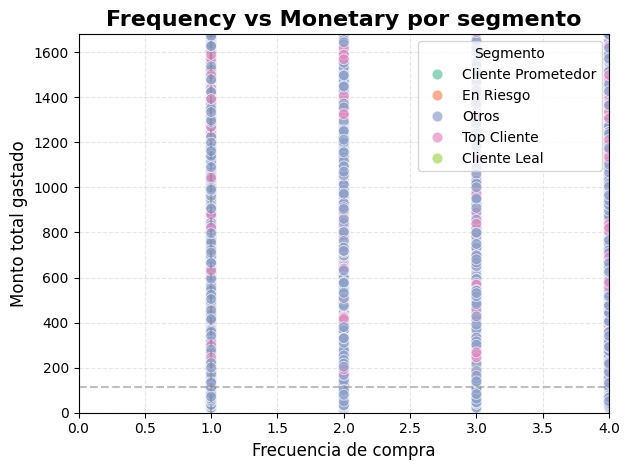

In [ ]:
sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="segmento",
    palette="Set2",
    alpha=0.7,
    s=60  # tamaño de los puntos
)

# Límites más controlados para mejor enfoque visual
plt.xlim(0, rfm["Frequency"].quantile(0.99))  # corta valores extremos
plt.ylim(0, rfm["Monetary"].quantile(0.99))

# Líneas de referencia (opcional)
plt.axhline(rfm["Monetary"].median(), linestyle="--", color="gray", alpha=0.5)
plt.axvline(rfm["Frequency"].median(), linestyle="--", color="gray", alpha=0.5)

# Títulos y etiquetas
plt.title("Frequency vs Monetary por segmento", fontsize=16, weight="bold")
plt.xlabel("Frecuencia de compra", fontsize=12)
plt.ylabel("Monto total gastado", fontsize=12)
plt.legend(title="Segmento", loc="upper right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()